# Deformable Contour Segmentation

#### Implement deformable contour segmentation based on the following algorithm. A couple of hints:
    • While working on your implementation, you can test with the included ‘ellipse.png’ which represents an ideal image with strong edges and no noise.
    • You can immediately update the snake point Pi you are working on, there is no need to keep a copy and update all at once.
    • Don’t forget to Gaussian blur before computing the gradients for generating the gradient magnitude Eimage. The amount of blurring may have an impact on your results.
    • Think about how you want to handle the relationship between P1 and PN. In other words, what do Pi-1 and Pi+1 mean in these cases?

    Author: Pruthviraj R Patil
    NYU ID: N16324281

In [160]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [161]:
#read image using path
def read_img(path):
    #status:complete
    img=cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = ((img_gray - np.min(img_gray)) * (1/(np.max(img_gray) - np.min(img_gray)) * 255)).astype('uint8')
    return img_gray

### 1. Define functions to create Gaussian Filter and operate it over the image using convolution on every iteration

In [162]:
def createGaussianFilter(n, stdev):
    #status: complete
    
    #task: creates a square gaussian filter
    #parameters: 
    #n= rows and column count
    #stdev= standard deviation
    
    variance=stdev*stdev #variance
    gaussian_filter=np.zeros((n, n))
    x=np.linspace(-n/2.0, n/2.0, n)
    y=np.linspace(-n/2.0, n/2.0, n)
    
    for i in range(0, n):
        for j in range(0, n):
            gaussian_filter[i, j]=(1/math.sqrt((2*math.pi*variance)))*math.exp(-(x[i]*x[i]+y[j]*y[j])/(2*variance))
    return gaussian_filter/np.sum(gaussian_filter.flatten())

In [163]:
def CommonUtil(image, init_x_size, init_y_size, pad_size, Mask):
    #status: complete
    #task: utility function to multiply kernel to image patch
    #output: adjusted image

    output_image= np.zeros((init_x_size, init_y_size))
    out_row=0
    out_col=0
    
    for x_pivot in range(pad_size, init_x_size+pad_size):
        out_col=0
        for y_pivot in range(pad_size, init_y_size+pad_size):
            patch=image[x_pivot-pad_size: x_pivot+pad_size+1, y_pivot-pad_size: y_pivot+pad_size+1]            
            output_image[out_row][out_col] = np.sum(np.multiply(Mask, patch))
            out_col+=1
        out_row+=1
    return output_image

In [164]:
def Convolve(image, Mask):
    #status: complete
    #task: perform Convolution 
    #parameters: image, Mask=kernel
    #returns: convolved image
    
    (init_x_size, init_y_size)=image.shape
    
    Mask=np.flipud(np.fliplr(Mask))
    pad_size=math.floor((Mask.shape[0])/2)
    image=np.pad(image, pad_size, mode='constant') 
    
    output_image= CommonUtil(image, init_x_size, init_y_size, pad_size, Mask)
    return output_image

In [165]:
def findMagnitude(xGrad, yGrad):
    #status: complete
    #params: xGrad, yGrad  
    #returns: magnitude using the x and y gradients       

    mags=np.zeros(xGrad.shape, np.float32)
#     print(mags.shape)
    x_len=xGrad.shape[0]
    y_len=xGrad.shape[1]
    for i in range(x_len):
        for j in range(y_len):
            mags[i][j]=np.sqrt(xGrad[i][j]**2 + yGrad[i][j]**2)%255
    return mags

### 2. Create the function to visualize images in subplots

In [166]:
def displayCorner(nRows, nCols, imgArray, nameArray):
    #status: complete
    #params: nrows, ncols, images array, names of the images,  
    #returns: subplots of given format
    
    c = 1  # initialize plot counter
    fig = plt.figure(figsize=(14,10))
    for i in imgArray:
        plt.subplot(nRows, nCols, c)
        plt.title(nameArray[c-1])
        plt.imshow(imgArray[c-1], cmap='gray')
        c = c + 1
    plt.show()

### 3. Define function to create the Snake

In [311]:
def create_snake(center_x, center_y, radius, num_pts):
    #status: complete
    samples = np.linspace(0, 2*math.pi, num_pts)
    snake = np.zeros((num_pts,2))
    snake[:,0] = np.round(radius * np.cos(samples) + center_x)
    snake[:,1] = np.round(radius * np.sin(samples) + center_y)
    return snake[:snake.shape[0],0], snake[:snake.shape[0],1]

In [312]:
def find_avg_distance(distances):
    summate=0
    for i in range(len(distances[0])-1):
        x1=distances[0][i]
        x2=distances[0][i+1]
        y1=distances[1][i]
        y2=distances[1][i+1]
        temp=math.sqrt((x2-x1)**2 + (y2-y1)**2)
        summate+=temp
    avg=summate/len(distances[0])
    return avg

In [313]:
def find_points_patch(point):
    temp_x, temp_y=(-1, -1)
    patch_points_x=[]
    patch_points_y=[]
    
    for i in range(3):
        temp_y=-1
        for j in range(3):
            patch_points_x.append(point[0]+temp_x)
            patch_points_y.append(point[1]+temp_y)
            temp_y+=1
        temp_x+=1
    return np.array(patch_points_x), np.array(patch_points_y)

In [314]:
def find_image_patch(point, image):
    patch=np.zeros((3, 3))
    temp_x, temp_y=(-1, -1)
    
    for i in range(patch.shape[0]):
        temp_y=-1
        for j in range(patch.shape[1]):
            if(((point[0]+temp_x)>= image.shape[0]) or ((point[1]+temp_y)>=image.shape[1])):
                continue
            patch[i][j]=image[int(point[0]+temp_x)][int(point[1]+temp_y)]
            temp_y+=1
        temp_x+=1
    return patch

In [315]:
def find_energy(avg_cor, patch, point_x, point_y, points_x, points_y, alpha, beta, gamma, current, prev, next_pt):
    #status: complete
    #find external energy    
    E_external= -sum(sum(patch))

    x1=points_x[prev]
    x2=point_x
    y1=points_y[prev]
    y2=point_y
    temp_1 = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    int_temp1 = (avg_cor-temp_1)**2
    
    #find internal energy
    a=(points_x[prev]-point_x)
    b=(points_x[next_pt]-point_x)
    int_temp2_x=(a+b)
    a=(points_y[prev]-point_y)
    b=(points_y[next_pt]-point_y)
    int_temp2_y=(a+b)
    int_temp2= int_temp2_x**2 +int_temp2_y**2
    Energy= alpha*int_temp1 + beta*int_temp2 + gamma*E_external    
    
    return Energy, current

In [316]:
def snake_iteration(image, x, y, alpha, beta, gamma, iterations):
    #status: complete
    x_prewitt_filter=np.array([[-1, -1, -1]])
    y_prewitt_filter=(np.array([[1, 1, 1]]).T) 
    conv_im_x=Convolve(image, x_prewitt_filter)
    conv_im_y=Convolve(image, y_prewitt_filter)
    mag_image=findMagnitude(conv_im_x, conv_im_y)
    
    for epoch in range(iterations):
        point_count, n_points=(len(x)-1, len(x))        
        
        for i in range(n_points):
            avg_cor=find_avg_distance([x, y])
            prev=point_count%n_points
            current=(point_count+1)%n_points
            next_pt=(point_count+2)%n_points
            point_count+=1
                        
            patch_point_x, patch_point_y = find_points_patch(np.array([x[i], y[i]]))
            
            Energy_store=[]

            for point in range(patch_point_x.shape[0]):
                image_patch = find_image_patch(np.array([patch_point_x[point], patch_point_y[point]]), mag_image)
                Energy, current=find_energy(avg_cor, image_patch, int(patch_point_x[point]), int(patch_point_y[point]), x, y, alpha, beta, gamma, current, prev, next_pt)
                Energy_store.append(Energy)
            
            min_val, min_idx = min((val, idx) for (idx, val) in enumerate(Energy_store))              

            x[current]=patch_point_x[min_idx]
            y[current]=patch_point_y[min_idx]
        
    return x, y

In [317]:
def run_snake_process(image, iterations, points_x, points_y, alpha, beta, gamma): 
    return snake_iteration(image, points_x, points_y, alpha, beta, gamma, iterations)

In [398]:
def main():
    image=read_img("astronaut.png")
    out_image = cv2.GaussianBlur(image,(101,101),10)
#     snake_contour_x, snake_contour_y= create_snake(441, 367, 320, 10) #ellipse
#     snake_contour_x, snake_contour_y= create_snake(441, 362, 320, 15) #impliedContour
#     snake_contour_x, snake_contour_y= create_snake(450, 360, 300, 50) #rectangle
#     snake_contour_x, snake_contour_y= constructRectangle(122, 614, 167, 744)
    snake_contour_x, snake_contour_y= create_snake(100, 225, 100, 50) #astronaut

#     epoches=50
    epoches=250
    xx, yy=(snake_contour_x.copy(), snake_contour_y.copy())
#     plt.plot(yy, xx)

#     alpha, beta, gamma=(0.002, 0.01, 0.0001)#ellipse
#     alpha, beta, gamma=(0.5, 0.05, 0.9)#implied
#     alpha, beta, gamma=(0.02, 0.001, 0.5) #rectangle
#     alpha, beta, gamma=(0.8, 0.001, 0.5) #rectangle

    alpha, beta, gamma=(0.15, 0.0015, 0.001) #astronaut

    snake_contour_x_, snake_contour_y_=run_snake_process(out_image, epoches, snake_contour_x, snake_contour_y, alpha, beta, gamma)
    plt.imshow(image, cmap="gray")
    plt.plot(yy, xx)
    plt.plot(snake_contour_y_, snake_contour_x_)

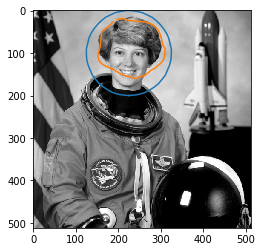

In [399]:
if __name__ == "__main__":
    main()

In [422]:
def disparityDepth(focal_length, T, depth_range, disparity_range):
    #status: complete
    disparity = np.linspace(0, disparity_range, disparity_range)
    y = ((focal_length)*T)/disparity
    disparity_plot=[]
    depth_plot=[]
    for i in range(len(y)):
        if(y[i]<depth_range):
            disparity_plot.append(disparity[i])
            depth_plot.append(y[i])
    plt.plot(disparity_plot, depth_plot, '-', linewidth=4)
    plt.xlabel("disparity (pixels)")
    plt.ylabel("depth (mm)")
    plt.title("disparity vs depth")

D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


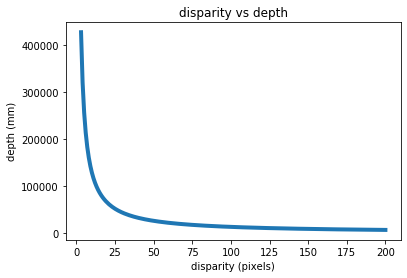

In [423]:
disparityDepth(300, 4300, 500000, 200)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


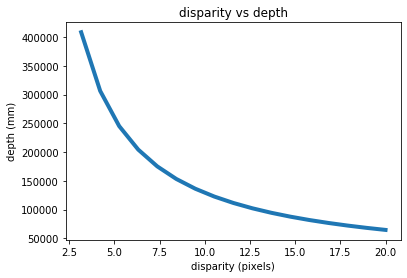

In [424]:
disparityDepth(300, 4300, 500000, 20)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


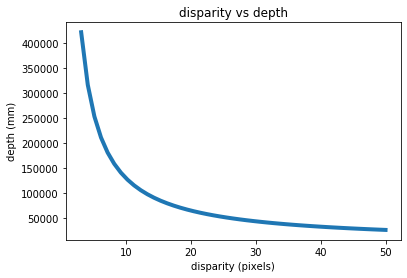

In [425]:
disparityDepth(300, 4300, 500000, 50)